In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage

In [2]:
from langchain_openai import ChatOpenAI
import re
model: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

pattern = r"<think>[\s\S]*?<\/think>"


## Memory

In [3]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
import os

db_path = "state_db/example.db"
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

## State

In [4]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    summary: str

## Node

In [5]:
def call_model(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = model.invoke(messages)
    
    return {"messages": response}

In [ ]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = f"Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)] # nếu đảo lại là sẽ bị dính 2 human mesages -> invoke kh có kết quả

    response = model.invoke(messages)
    response = re.sub(pattern, "", response.content)
    
    delete_msg = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"messages": delete_msg, "summary": response}

## Build graph

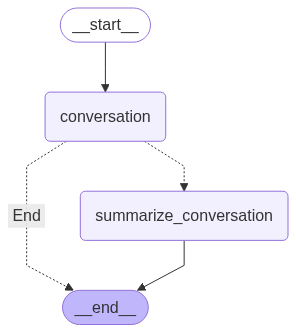

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

def should_continue(state: State):
    return "summarize_conversation" if len(state["messages"]) > 6 else "End"


workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "End": END         
    }
)
workflow.add_edge("summarize_conversation", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

In [9]:
# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user just said "hi! I'm Lance." So they're introducing themselves as Lance. Let me see how to respond appropriately.

First, I should acknowledge their greeting and mention that I'm here to help. Since the previous conversation was about Nick Bosa and his salary, maybe I can keep the tone friendly and offer assistance with any questions related to football or other topics.

I need to make sure my response is welcoming and open-ended. Maybe ask how they're doing or if there's anything specific they want to discuss. Also, since they mentioned being Lance, perhaps add a bit of enthusiasm to keep it light.

Wait, the user might be looking for a conversation starter. I should encourage them to share more about themselves or their interests. Maybe mention that I'm here to help with any questions they have, whether it's about football, other topics, or just general chat.

I should avoid being t

In [10]:
input_message = HumanMessage(
    content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

<think>
Okay, let's see. The user asked if Nick Bosa is the highest-paid defensive player. I need to clarify that while he's a top defender, his salary isn't the highest among all defensive players.

First, I should mention his position and reputation as a leader. Then, list some other high-paid defenders like T.J. Watt or Jalen Reagor. Compare their salaries to Bosa's. Also, note that defensive players have different roles, so the highest pay might vary by position. Finally, offer to help with more questions about football or the 49ers.
</think>

Hey Lance! 😊 Nick Bosa is definitely a top-tier defender, known for his leadership and impact on the field. While he’s one of the most respected players in the league, **his salary isn’t the highest among all defensive players**. For example, T.J. Watt and Jalen Reagor are often cited as some of the highest-paid defensive linemen, with salaries exceeding $100 mi

In [11]:
config = {"configurable": {"thread_id": "2"}}
graph_state = graph.get_state(config)
graph_state.values['summary']

'\n\n**Summary of the Conversation:**  \nThe conversation began with the user expressing interest in Nick Bosa and whether he is the highest-paid defensive player. The assistant clarified that while Bosa is a top-tier defender, his salary isn’t the highest among all defensive players. The user then mentioned liking the 49ers, prompting the assistant to acknowledge their enthusiasm for the team. The interaction continued with friendly exchanges about football, the 49ers’ roster, and the assistant offering help with questions. The user’s name was not provided, and the conversation remained light-hearted and supportive.'

In [12]:
graph_state.values.keys()

dict_keys(['messages', 'summary'])